## Implementation of naive DART trading strategies

We notice that on average the DART is positive (risk premium), so let run a naive DART trading strategy: always buying the DA and selling the RT and see the performance metrics

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from time import sleep
from utils import *
import numpy as np

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
USERNAME = 'tmaret@uchicago.edu'
PASSWORD = 'PowerMarket2025'
SUBSCRIPTION_KEY = '9f1e472b26a5439d84f564bf038e46fa' 

# Authorization URL for signing into ERCOT Public API account
AUTH_URL = f'https://ercotb2c.b2clogin.com/ercotb2c.onmicrosoft.com/B2C_1_PUBAPI-ROPC-FLOW/oauth2/v2.0/token\
?username={USERNAME}\
&password={PASSWORD}\
&grant_type=password\
&scope=openid+fec253ea-0d06-4272-a5e6-b478baeecd70+offline_access\
&client_id=fec253ea-0d06-4272-a5e6-b478baeecd70\
&response_type=id_token'

# Sign In/Authenticate
auth_response = requests.post(AUTH_URL)

# Retrieve access token
access_token = auth_response.json().get("access_token")
print(auth_response)

<Response [200]>


In [3]:
list_of_zones = ['HB_HOUSTON', 'HB_WEST', 'HB_SOUTH', 'HB_NORTH', 'HB_PAN']


## get the dart prices

In [11]:
da_data = pd.DataFrame()
for code in list_of_zones:
    lmp_da = pd.read_csv(f'C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/Power_Market-1/Data/da_lmp_{code}.csv')
    ## get hourly data
    lmp_da['deliveryDate'] = pd.to_datetime(lmp_da['deliveryDate'])
    lmp_da['hourEnding'] = lmp_da['hourEnding'].apply(lambda x: int(x.split(':')[0]))
    lmp_da = lmp_da.rename(columns={'settlementPointPrice': code+'_da', 'deliveryDate': 'date', 'hourEnding': 'hour'})[['date', 'hour', code+'_da']]
    if da_data.empty:
        da_data = lmp_da
    else:
        da_data = pd.merge(da_data, lmp_da, on=['date', 'hour'], how='outer')
da_data['date'] = pd.to_datetime(da_data['date'])

rt_data = pd.DataFrame()

for code in list_of_zones:
    lmp_rt = pd.read_parquet(f'C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/Power_Market-1/Data/rtm_LMP_{code}.parquet')
    ## get hourly data
    lmp_rt['SCEDTimestamp'] = pd.to_datetime(lmp_rt['SCEDTimestamp'])
    ## create a new df that aggregates all the LMPs for each hour : do equal weighted average
    lmp_rt['hour'] = lmp_rt['SCEDTimestamp'].dt.hour
    lmp_rt['date'] = lmp_rt['SCEDTimestamp'].dt.date

    rtm_hourly = lmp_rt.groupby(['date', 'hour'])['LMP'].mean().reset_index()
    rtm_hourly['date'] = pd.to_datetime(rtm_hourly['date'])

    rtm_hourly = rtm_hourly.rename(columns={'LMP': code})
    if rt_data.empty:
        rt_data = rtm_hourly
    else:
        rt_data = pd.merge(rt_data, rtm_hourly, on=['date', 'hour'], how='outer')
rt_data['date'] = pd.to_datetime(rt_data['date'])


## merge the two datasets
data = pd.merge(da_data, rt_data, on=['date', 'hour'], how='outer')
data = data.sort_values(by=['date', 'hour'])

## get da - rt spread
for code in list_of_zones:
    data[code+'_spread'] = data[code+'_da'] - data[code]

dart_prices = data[['date', 'hour'] + [code+'_spread' for code in list_of_zones]]
dart_prices = dart_prices.dropna()

In [20]:
print(dart_prices.isnull().sum())
dart_prices.tail()

## plot correlation matrix
import seaborn as sns
corr = dart_prices[[code+'_spread' for code in list_of_zones]].corr()
display(corr)

## print spread statistics
summary = dart_prices[[code+'_spread' for code in list_of_zones]].describe()
display(summary)

date                 0
hour                 0
HB_HOUSTON_spread    0
HB_WEST_spread       0
HB_SOUTH_spread      0
HB_NORTH_spread      0
HB_PAN_spread        0
dtype: int64


,HB_HOUSTON_spread,HB_WEST_spread,HB_SOUTH_spread,HB_NORTH_spread,HB_PAN_spread
HB_HOUSTON_spread,1.000000,0.944159,0.986205,0.947435,0.938034
HB_WEST_spread,0.944159,1.000000,0.948074,0.986348,0.982243
HB_SOUTH_spread,0.986205,0.948074,1.000000,0.946433,0.938001
HB_NORTH_spread,0.947435,0.986348,0.946433,1.000000,0.987444
HB_PAN_spread,0.938034,0.982243,0.938001,0.987444,1.000000


,HB_HOUSTON_spread,HB_WEST_spread,HB_SOUTH_spread,HB_NORTH_spread,HB_PAN_spread
count,9735.000000,9735.000000,9735.000000,9735.000000,9735.000000
mean,1.673207,1.655743,1.388974,1.290883,1.770386
std,66.136716,71.965482,65.074052,71.611965,72.088977
min,-2784.165714,-2749.602857,-2805.918571,-2765.710714,-2755.485714
25%,-3.706667,-4.452083,-3.364167,-4.053333,-5.066250
50%,0.802500,1.717500,1.195833,0.927500,0.750000
75%,6.268750,8.520833,6.402280,6.506667,8.072949
max,1806.578462,1882.021667,1795.089231,1868.623333,1866.793333


when looking at the statistics we see that the average spread is higher when the std is higher (risk premium) as well as a lower 25% quantile

## Implement Naive trading strategy

for each hub, we buy the spread

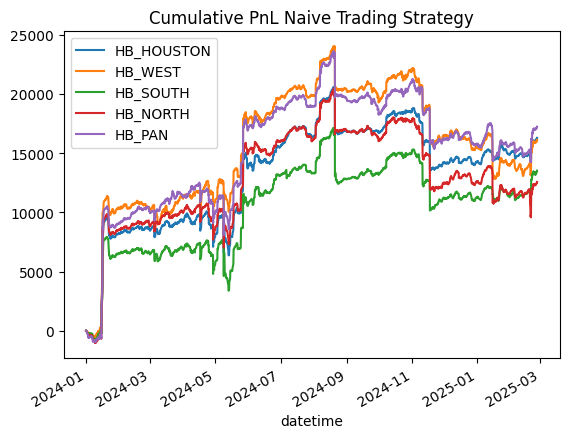

,PnL,Sharpe Ratio,Max Drawdown,semi variance
HB_HOUSTON,16288.669523,0.02297,-1.951302,0.031593
HB_WEST,16118.653947,0.001846,-30.351897,0.478661
HB_SOUTH,13521.665411,0.017151,-3.896713,0.062430
HB_NORTH,12566.743047,0.01062,-4.36875,0.068291
HB_PAN,17234.711135,0.009932,-7.841564,0.117727


In [ ]:
def backtest_naive_trading_strategy(spread_data, list_of_zones = list_of_zones):
    col = list_of_zones
    df = pd.DataFrame(columns=col, index=spread_data.index)
    df['datetime'] = spread_data['date']+spread_data['hour'].apply(lambda x: timedelta(hours=x))
    ## we always long the spread
    for zone in list(col):
        df[zone] = np.cumsum(spread_data[zone+'_spread'])
    df = df.set_index('datetime')
    return df

naive_trading = backtest_naive_trading_strategy(dart_prices, list_of_zones = list_of_zones)

## plot the backtest
naive_trading.plot()
plt.title('Cumulative PnL Naive Trading Strategy')
plt.show()

## print performance statistics
summary = pd.DataFrame(index=list_of_zones, columns=['PnL', 'Sharpe Ratio', 'Max Drawdown'])
for zone in list_of_zones:
    summary.loc[zone, 'PnL'] = naive_trading[zone].iloc[-1]
    summary.loc[zone, 'Sharpe Ratio'] = naive_trading[zone].pct_change().mean()/naive_trading[zone].pct_change().std()
    summary.loc[zone, 'Max Drawdown'] = naive_trading[zone].pct_change().min()
    summary.loc[zone, 'semi variance'] = naive_trading[zone].pct_change()[naive_trading[zone].pct_change()<0].std()
display(summary)